In [1]:
## Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.autograd import Variable
from tqdm import tqdm
from skimage import io, transform
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


## Modify `PATH` to `your_directory/saved_model.pth` 
This is needed for saving/loading of the model.

In [2]:
PATH = "./saved_model.pth"

In [3]:
size = (150, 150)
classes = {0: 'normal', 1: 'covid', 2:'non_covid'}
print (classes)

{0: 'normal', 1: 'covid', 2: 'non_covid'}


In [4]:
groups = ['train', 'test', 'val']
print(groups)

['train', 'test', 'val']


In [5]:
dataset_numbers = {'train_normal': 1341,\
                   'train_covid': 1345,\
                   'train_non_covid':2530,\
                   'val_normal': 8,\
                   'val_covid': 8,\
                   'val_non_covid': 8,\
                   'test_normal': 234,\
                   'test_covid': 138,\
                   'test_non_covid':242}
print(list(dataset_numbers.values())[0])

1341


In [6]:
dataset_paths = {'train_normal': './dataset/train/normal/',\
                   'train_covid': './dataset/train/infected/covid/',\
                   'train_non_covid': './dataset/train/infected/non_covid/',\
                   'val_normal': './dataset/val/normal',\
                   'val_covid': './dataset/val/infected/covid',\
                   'val_non_covid':'./dataset/val/infected/non_covid',\
                   'test_normal': './dataset/test/normal',\
                   'test_covid': './dataset/test/infected/covid',\
                   'test_non_covid':'./dataset/test/infected/non_covid'}
print(dataset_paths)

{'train_normal': './dataset/train/normal/', 'train_covid': './dataset/train/infected/covid/', 'train_non_covid': './dataset/train/infected/non_covid/', 'val_normal': './dataset/val/normal', 'val_covid': './dataset/val/infected/covid', 'val_non_covid': './dataset/val/infected/non_covid', 'test_normal': './dataset/test/normal', 'test_covid': './dataset/test/infected/covid', 'test_non_covid': './dataset/test/infected/non_covid'}


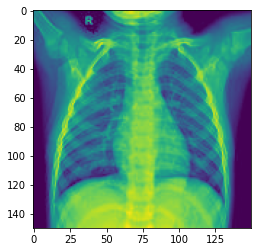

In [7]:
path_to_file = './dataset/train/normal/10.jpg'
with open(path_to_file, 'rb') as f:
    im = np.asarray(Image.open(f))
    plt.imshow(im)
f.close()

In [8]:
print (im.shape)
print(im)

(150, 150)
[[106 112 100 ...  13  15  16]
 [101 114 112 ...  23  25  27]
 [101 110 121 ...  39  41  43]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


# Dataset

In [9]:
class Lung_Dataset(Dataset):
    """
    Generic Dataset class.
    """
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'covid', 2: 'non_covid'}
        
        # The dataset has been split in training, testing and validation datasets
        self.groups = ['train', 'test', 'val']
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,\
                               'train_covid': 1345,\
                               'train_non_covid':2530,\
                               'val_normal': 8,\
                               'val_covid': 8,\
                               'val_non_covid': 8,\
                               'test_normal': 234,\
                               'test_covid': 138,\
                               'test_non_covid':242}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                               'train_covid': './dataset/train/infected/covid/',\
                               'train_non_covid': './dataset/train/infected/non_covid/',\
                               'val_normal': './dataset/val/normal',\
                               'val_covid': './dataset/val/infected/covid',\
                               'val_non_covid':'./dataset/val/infected/non_covid',\
                               'test_normal': './dataset/test/normal',\
                               'test_covid': './dataset/test/infected/covid',\
                               'test_non_covid':'./dataset/test/infected/non_covid'}

        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "Images have been split in three groups: training, testing and validation sets.\n"
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' , 'covid' , 'non-covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' , 'covid' , 'non_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Convert to Numpy array and normalize pixel values by dividing by 255.
#             im = np.asarray(Image.open(f).convert('RGB'))/255
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)

In [10]:
ld = Lung_Dataset()
ld.describe()

This is the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5854 images, of size 150 by 150.
Images have been split in three groups: training, testing and validation sets.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_covid, in folder ./dataset/train/infected/covid/: 1345 images.
 - train_non_covid, in folder ./dataset/train/infected/non_covid/: 2530 images.
 - val_normal, in folder ./dataset/val/normal: 8 images.
 - val_covid, in folder ./dataset/val/infected/covid: 8 images.
 - val_non_covid, in folder ./dataset/val/infected/non_covid: 8 images.
 - test_normal, in folder ./dataset/test/normal: 234 images.
 - test_covid, in folder ./dataset/test/infected/covid: 138 images.
 - test_non_covid, in folder ./dataset/test/infected/non_covid: 242 images.



In [11]:
im = ld.open_img('train', 'normal', 1)
print(im.shape)
print(im)

(150, 150)
[[0.05882353 0.09803922 0.12941176 ... 0.11764706 0.10196078 0.0745098 ]
 [0.0627451  0.09803922 0.12941176 ... 0.11764706 0.09803922 0.0745098 ]
 [0.06666667 0.10196078 0.13333333 ... 0.11372549 0.09803922 0.0745098 ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


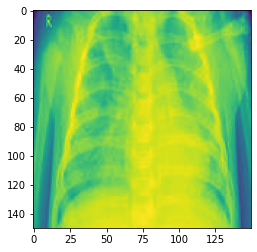

In [12]:
ld.show_img('train', 'non_covid', 10)

# Train Dataset

In [13]:
class Lung_Train_Dataset(Dataset):
    
    def __init__(self, transforms=None):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'covid', 2:'non_covid'}
        
        # The dataset consists only of training images
        self.groups = 'train'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,\
                                   'train_covid': 1345,\
                                   'train_non_covid':2530}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                               'train_covid': './dataset/train/infected/covid/',\
                               'train_non_covid': './dataset/train/infected/non_covid/'}
           
        self.transforms = transforms
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' , 'covid' , 'non-covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' , 'covid' , 'non_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
#             im = np.asarray(Image.open(f).convert('RGB'))/255
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' , 'covid' , 'non_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[0]+list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = 0
        elif index < second_val:
            class_val = 'covid'
            index = index - first_val
            label = 1
        else :
            class_val = 'non_covid'
            index = index - second_val
            label = 2
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        
        if self.transforms:
            im = transforms.functional.to_pil_image(im)
            im = self.transforms(im)
            im = transforms.ToTensor()(im).unsqueeze_(0)
            
        return im, label

In [14]:
# without data augmentation
ld_train = Lung_Train_Dataset()
ld_train.describe()

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_covid, in folder ./dataset/train/infected/covid/: 1345 images.
 - train_non_covid, in folder ./dataset/train/infected/non_covid/: 2530 images.



In [15]:
print(len(ld_train))

5216


In [16]:
im, class_oh = ld_train[1341]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.2667, 0.2745, 0.3020,  ..., 0.1255, 0.0980, 0.0863],
         [0.2941, 0.3098, 0.3294,  ..., 0.1373, 0.1059, 0.0902],
         [0.2980, 0.3373, 0.3608,  ..., 0.1216, 0.0941, 0.0784],
         ...,
         [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]]])
1


# Test Dataset

In [17]:
class Lung_Test_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'covid', 2:'non_covid'}
        
        # The dataset consists only of training images
        self.groups = 'test'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'test_normal': 234,\
                               'test_covid': 138,\
                               'test_non_covid':242}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'test_normal': './dataset/test/normal/',\
                               'test_covid': './dataset/test/infected/covid/',\
                               'test_non_covid': './dataset/test/infected/non_covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' , 'covid' , 'non-covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' , 'covid' , 'non_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
#             im = np.asarray(Image.open(f).convert('RGB'))/255
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' , 'covid' , 'non_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[0]+list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = 0
        elif index < second_val:
            class_val = 'covid'
            index = index - first_val
            label = 1
        else :
            class_val = 'non_covid'
            index = index -second_val
            label = 2
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [18]:
ld_test = Lung_Test_Dataset()
ld_test.describe()

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 614 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_normal, in folder ./dataset/test/normal/: 234 images.
 - test_covid, in folder ./dataset/test/infected/covid/: 138 images.
 - test_non_covid, in folder ./dataset/test/infected/non_covid/: 242 images.



In [19]:
print(len(ld_test))

614


In [20]:
im, class_oh = ld_test[613]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0471, 0.0588, 0.0784,  ..., 0.3020, 0.2941, 0.2902],
         [0.0627, 0.0824, 0.1020,  ..., 0.3255, 0.3176, 0.3098],
         [0.0941, 0.1137, 0.1451,  ..., 0.3333, 0.3294, 0.3216],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
2


In [21]:
class Lung_Val_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'covid', 2:'non_covid'}
        
        # The dataset consists only of training images
        self.groups = 'val'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'val_normal': 8,\
                               'val_covid': 8,\
                               'val_non_covid': 8}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'val_normal': './dataset/val/normal/',\
                               'val_covid': './dataset/val/infected/covid/',\
                               'val_non_covid': './dataset/val/infected/non_covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' , 'covid' , 'non-covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' , 'covid' , 'non_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
#             im = np.asarray(Image.open(f).convert('RGB'))/255
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' , 'covid' , 'non_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[0]+list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = 0
        elif index < second_val:
            class_val = 'covid'
            index = index - first_val
            label = 1
        else :
            class_val = 'non_covid'
            index = index - second_val
            label = 2
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [22]:
ld_val = Lung_Val_Dataset()
ld_val.describe()

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 24 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset/val/normal/: 8 images.
 - val_covid, in folder ./dataset/val/infected/covid/: 8 images.
 - val_non_covid, in folder ./dataset/val/infected/non_covid/: 8 images.



In [23]:
print(len(ld_val))

24


In [24]:
im, class_oh = ld_val[3]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.2627, 0.2392, 0.3686,  ..., 0.0863, 0.0784, 0.0588],
         [0.0784, 0.1255, 0.3725,  ..., 0.0745, 0.0745, 0.0627],
         [0.2902, 0.2863, 0.4824,  ..., 0.0745, 0.0824, 0.0667],
         ...,
         [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0314, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
0


# Dataloader

In [25]:
bs_val = 4

In [26]:
# Dataloader from dataset (train)
train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)
print(train_loader)
# Dataloader from dataset (test)
test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
print(test_loader)
# Dataloader from dataset (val)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)
print(val_loader)

dataloaders_dict = {'train': train_loader, 'test': test_loader}  # no transformation yet

# Test model and plots

In [27]:
def plot_graph(train_loss, train_acc, test_loss, test_acc , epoch):
    plt.figtext(.5,.9,'Training/Validation losses over {} epochs'.format(epoch), fontsize=15, ha='center')
    plt.plot(train_loss, label = "Training Loss")
    plt.plot(train_acc, label = "Training Acc")
    plt.plot(test_loss, label = 'Test Loss')
    plt.plot(test_acc, label = 'Test Acc')
    plt.xlabel('Number of Epoch', fontsize = 14)
    plt.ylabel('Loss', fontsize = 14)
    plt.legend()

In [28]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss = []
    train_acc = []
    test_acc= []
    test_loss = []
    
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                test_loss.append(epoch_loss)
                test_acc.append(epoch_acc)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                # save model 
                torch.save(model.state_dict(), PATH)
                
        print("Epoch: {}/{} - ".format(epoch+1, num_epochs),
                  "Training Loss: {:.3f} - ".format(train_loss[epoch]),
                  "Training Accuracy: {:.3f} - ".format(train_acc[epoch]),
                  "Test Loss: {:.3f} - ".format(test_loss[epoch]),
                  "Test Accuracy: {:.3f}".format(test_acc[epoch]))
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plot_graph(train_loss, train_acc, test_loss, test_acc, num_epochs)
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, test_acc

# Model

The model is inpsired by VGG architecture where convolutional layers are stack on top of each other.  

In [29]:
# A new model with stacked convolutional layers
class New_NN(nn.Module):
    def __init__(self, num_classes=3):
        super(New_NN, self).__init__()
        self.conv0 = nn.Conv2d(1, 64, 3, 1)        
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        
        self.conv5 = nn.Conv2d(64, 128, 3, 1)
        self.conv7 = nn.Conv2d(128, 128, 3, 1)
        self.conv10 = nn.Conv2d(128, 256, 3, 1)
        
        self.conv12 = nn.Conv2d(256, 256, 3, 1)
        self.conv14 = nn.Conv2d(256, 256, 3, 1)
        
        self.conv17 = nn.Conv2d(256, 512, 3, 1)
        self.conv19 = nn.Conv2d(512, 512, 3, 1)
        self.conv21 = nn.Conv2d(512, 512, 3, 1)
        
        self.conv24 = nn.Conv2d(512, 512, 3, 1)
        
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2, 0)
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096), 
            nn.ReLU(inplace=True), 
            nn.Dropout(0.5), 
            nn.Linear(4096, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), 
            nn.Linear(4096, num_classes)
        )
           
    def forward(self, x):
        x = self.conv0(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv7(x)
        x = self.relu(x)
        x = self.pool(x)
            
        x = self.conv10(x)
        x = self.relu(x)
        x = self.conv12(x)
        x = self.relu(x)
        x = self.conv14(x)
        x = self.relu(x)     
        x = self.pool(x)
        
        x = self.conv17(x)
        x = self.relu(x)
        x = self.conv19(x)
        x = self.relu(x)
        x = self.conv21(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv24(x)
        x = self.relu(x)
        x = self.pool(x)  
        
        x = self.avgpool(x) 
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def initialise_weights(self):
    for m in self.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)): 
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

def initialise_weights_xavier(self):
    for m in self.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)): 
            nn.init.xavier_uniform_(m.weight)


# Training Model

Skip to **Load Model** to just load the model.

  0%|          | 5/1304 [00:00<00:28, 46.27it/s]

Epoch: 1/15 -  Training Loss: 1.037 -  Training Accuracy: 0.498 -  Test Loss: 0.877 -  Test Accuracy: 0.632


  0%|          | 5/1304 [00:00<00:27, 46.48it/s]

Epoch: 2/15 -  Training Loss: 0.803 -  Training Accuracy: 0.638 -  Test Loss: 1.020 -  Test Accuracy: 0.581


  0%|          | 5/1304 [00:00<00:27, 46.55it/s]

Epoch: 3/15 -  Training Loss: 0.659 -  Training Accuracy: 0.700 -  Test Loss: 1.138 -  Test Accuracy: 0.516


  0%|          | 5/1304 [00:00<00:28, 46.39it/s]

Epoch: 4/15 -  Training Loss: 0.596 -  Training Accuracy: 0.723 -  Test Loss: 0.629 -  Test Accuracy: 0.800


  0%|          | 5/1304 [00:00<00:28, 46.07it/s]

Epoch: 5/15 -  Training Loss: 0.542 -  Training Accuracy: 0.760 -  Test Loss: 0.661 -  Test Accuracy: 0.752


  0%|          | 5/1304 [00:00<00:28, 44.98it/s]

Epoch: 6/15 -  Training Loss: 0.521 -  Training Accuracy: 0.766 -  Test Loss: 0.704 -  Test Accuracy: 0.762


  0%|          | 5/1304 [00:00<00:28, 46.29it/s]

Epoch: 7/15 -  Training Loss: 0.486 -  Training Accuracy: 0.786 -  Test Loss: 0.957 -  Test Accuracy: 0.736


  0%|          | 5/1304 [00:00<00:28, 46.02it/s]

Epoch: 8/15 -  Training Loss: 0.461 -  Training Accuracy: 0.792 -  Test Loss: 1.032 -  Test Accuracy: 0.705


  0%|          | 5/1304 [00:00<00:27, 46.68it/s]

Epoch: 9/15 -  Training Loss: 0.445 -  Training Accuracy: 0.803 -  Test Loss: 1.224 -  Test Accuracy: 0.678


  0%|          | 5/1304 [00:00<00:28, 46.00it/s]

Epoch: 10/15 -  Training Loss: 0.429 -  Training Accuracy: 0.809 -  Test Loss: 1.672 -  Test Accuracy: 0.554


  0%|          | 5/1304 [00:00<00:28, 45.83it/s]

Epoch: 11/15 -  Training Loss: 0.409 -  Training Accuracy: 0.815 -  Test Loss: 1.089 -  Test Accuracy: 0.710


  0%|          | 5/1304 [00:00<00:27, 46.51it/s]

Epoch: 12/15 -  Training Loss: 0.385 -  Training Accuracy: 0.825 -  Test Loss: 1.621 -  Test Accuracy: 0.658


  0%|          | 5/1304 [00:00<00:28, 46.05it/s]

Epoch: 13/15 -  Training Loss: 0.371 -  Training Accuracy: 0.837 -  Test Loss: 0.985 -  Test Accuracy: 0.736


  0%|          | 5/1304 [00:00<00:28, 46.25it/s]

Epoch: 14/15 -  Training Loss: 0.324 -  Training Accuracy: 0.860 -  Test Loss: 1.494 -  Test Accuracy: 0.619


100%|██████████| 154/154 [00:01<00:00, 138.68it/s]


Epoch: 15/15 -  Training Loss: 0.326 -  Training Accuracy: 0.860 -  Test Loss: 1.340 -  Test Accuracy: 0.692
Training complete in 7m 46s
Best val Acc: 0.799674


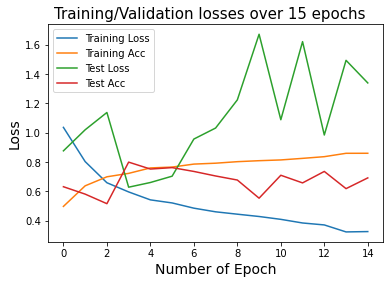

In [30]:
num_classes = 3
num_epochs = 15
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = New_NN()
model_ft.apply(initialise_weights) # initialise weights

scratch_model = model_ft.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

# Load Model

In [93]:
load_model = True

if load_model:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    scratch_model = New_NN()
    scratch_model.load_state_dict(torch.load(PATH))
    scratch_model.eval()

# Validation and Display Results

In [104]:
def validation(model, val_loader):
    model.to(device)
#     model.eval()
    correct = 0
    total = 0
    pred = []
    false_neg = 0
    class_correct = list(0. for i in range(3)) # 3 classes
    class_total = list(0. for i in range(3)) # 3 classes
    img_label = [] 
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)  
        outputs = model.forward(images)        
        _, predicted = torch.max(outputs.data, 1)
        
        # overall accuarcy of the model
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # class-wise accuarcy of the model
        c = (predicted == labels).squeeze()
    
        for i in range(4): # batch size of 4
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            label_list =labels.tolist()
            img_label.append(tuple((images[i], label_list[i])))
            if predicted.tolist()[i] == 0:
                pred.append("normal")
                if label_list[i] == 1:
                    false_neg+=1
            elif predicted.tolist()[i] == 1:
                pred.append("covid")
            else:
                pred.append("non_covid")
                if label_list[i] == 1:
                    false_neg+=1
    
    overall_acc = 100 * correct / total
    class_acc = {}
    for i in range(3):
        acc = 100 * class_correct[i] / 8
        class_acc[classes[i]] = acc
        print('Accuracy of %5s : %2d %%' % (classes[i], acc))        
    print("-----------------------------")        
    print("Accuracy of the model: {:.1f}%".format(overall_acc))
    print("Number of false negative of covid: {}/8".format(false_neg))
    
    return correct, overall_acc, class_acc, pred, img_label, false_neg 


100%|██████████| 6/6 [00:00<00:00, 113.08it/s]

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 24 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset/val/normal/: 8 images.
 - val_covid, in folder ./dataset/val/infected/covid/: 8 images.
 - val_non_covid, in folder ./dataset/val/infected/non_covid/: 8 images.

Accuracy of normal : 87 %
Accuracy of covid : 87 %
Accuracy of non_covid : 37 %
-----------------------------
Accuracy of the model: 70.8%
Number of false negative of covid: 1/8


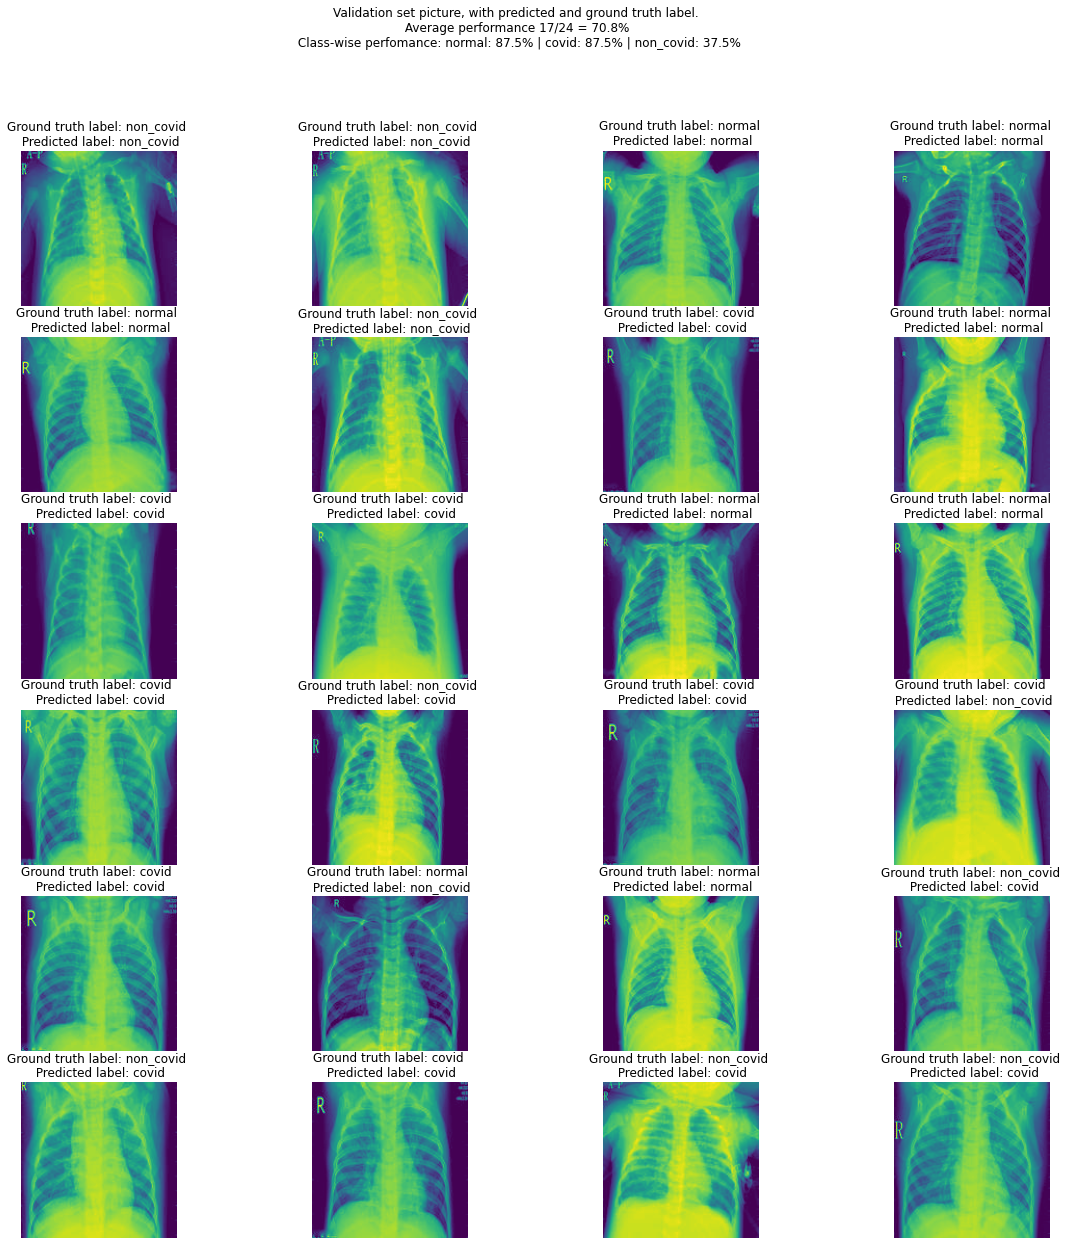

In [105]:
ld_val = Lung_Val_Dataset()
ld_val.describe()

correct, overall_acc, class_acc, pred, img_label, false_neg= validation(scratch_model, val_loader)

class_val = ['normal', 'covid', 'non_covid']
fig = plt.figure(figsize=(20, 20))
fig.tight_layout() 
fig.suptitle("Validation set picture, with predicted and ground truth label. \n Average performance {}/24 = {:.1f}% \n Class-wise perfomance: normal: {}% | covid: {}% | non_covid: {}%".format(correct, overall_acc, class_acc["normal"], class_acc["covid"], class_acc["non_covid"]))
for i in range(len(img_label)):
    ax = plt.subplot(6, 4, i+1)
    label = None
    if img_label[i][1] == 0:
        label = "normal"
    elif img_label[i][1] == 1:
        label = "covid"
    else:
        label = "non_covid"       
    ax.set_title('Ground truth label: {} \n Predicted label: {}'.format(label, pred[i]))
    ax.axis('off')
    plt.imshow(torch.squeeze(img_label[i][0].cpu()))


 # Load from pytorch (test which architecture is better)

# ResNet

  0%|          | 5/1304 [00:00<00:27, 47.14it/s]

Epoch: 1/10 -  Training Loss: 0.786 -  Training Accuracy: 0.652 -  Test Loss: 1.437 -  Test Accuracy: 0.580


  0%|          | 5/1304 [00:00<00:27, 47.56it/s]

Epoch: 2/10 -  Training Loss: 0.603 -  Training Accuracy: 0.735 -  Test Loss: 0.849 -  Test Accuracy: 0.715


  1%|          | 7/1304 [00:00<00:22, 58.73it/s]

Epoch: 3/10 -  Training Loss: 0.488 -  Training Accuracy: 0.785 -  Test Loss: 1.069 -  Test Accuracy: 0.702


  0%|          | 6/1304 [00:00<00:23, 55.30it/s]

Epoch: 4/10 -  Training Loss: 0.429 -  Training Accuracy: 0.817 -  Test Loss: 1.039 -  Test Accuracy: 0.713


  1%|          | 7/1304 [00:00<00:20, 63.66it/s]

Epoch: 5/10 -  Training Loss: 0.392 -  Training Accuracy: 0.827 -  Test Loss: 1.157 -  Test Accuracy: 0.687


  0%|          | 6/1304 [00:00<00:23, 55.49it/s]

Epoch: 6/10 -  Training Loss: 0.377 -  Training Accuracy: 0.833 -  Test Loss: 1.265 -  Test Accuracy: 0.648


  0%|          | 5/1304 [00:00<00:27, 46.57it/s]

Epoch: 7/10 -  Training Loss: 0.320 -  Training Accuracy: 0.867 -  Test Loss: 1.244 -  Test Accuracy: 0.707


  1%|          | 7/1304 [00:00<00:21, 59.05it/s]

Epoch: 8/10 -  Training Loss: 0.275 -  Training Accuracy: 0.886 -  Test Loss: 0.880 -  Test Accuracy: 0.710


  0%|          | 6/1304 [00:00<00:24, 53.74it/s]

Epoch: 9/10 -  Training Loss: 0.268 -  Training Accuracy: 0.891 -  Test Loss: 1.342 -  Test Accuracy: 0.686


100%|██████████| 154/154 [00:01<00:00, 121.58it/s]


Epoch: 10/10 -  Training Loss: 0.224 -  Training Accuracy: 0.907 -  Test Loss: 1.492 -  Test Accuracy: 0.640
Training complete in 4m 6s
Best val Acc: 0.714984


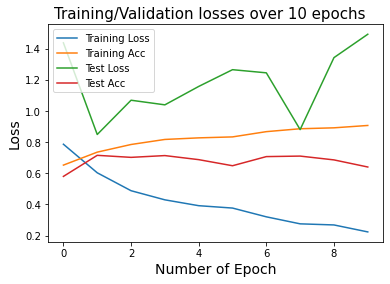

In [87]:
# Number of classes in the dataset
num_classes = 3

# Number of epochs to train for
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=False)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# Initialize the non-pretrained version of the model used for this run
scratch_model = model_ft.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

## DenseNet

  0%|          | 2/1304 [00:00<01:52, 11.58it/s]

Epoch: 1/10 -  Training Loss: 0.787 -  Training Accuracy: 0.649 -  Test Loss: 0.833 -  Test Accuracy: 0.684


  0%|          | 2/1304 [00:00<02:03, 10.53it/s]

Epoch: 2/10 -  Training Loss: 0.678 -  Training Accuracy: 0.707 -  Test Loss: 0.673 -  Test Accuracy: 0.738


  0%|          | 2/1304 [00:00<01:36, 13.43it/s]

Epoch: 3/10 -  Training Loss: 0.630 -  Training Accuracy: 0.730 -  Test Loss: 0.687 -  Test Accuracy: 0.764


  0%|          | 2/1304 [00:00<01:34, 13.73it/s]

Epoch: 4/10 -  Training Loss: 0.575 -  Training Accuracy: 0.750 -  Test Loss: 0.752 -  Test Accuracy: 0.733


  0%|          | 2/1304 [00:00<01:36, 13.43it/s]

Epoch: 5/10 -  Training Loss: 0.541 -  Training Accuracy: 0.767 -  Test Loss: 0.602 -  Test Accuracy: 0.779


  0%|          | 2/1304 [00:00<02:06, 10.30it/s]

Epoch: 6/10 -  Training Loss: 0.522 -  Training Accuracy: 0.770 -  Test Loss: 0.706 -  Test Accuracy: 0.792


  0%|          | 2/1304 [00:00<01:35, 13.57it/s]

Epoch: 7/10 -  Training Loss: 0.493 -  Training Accuracy: 0.787 -  Test Loss: 0.841 -  Test Accuracy: 0.739


  0%|          | 2/1304 [00:00<01:47, 12.07it/s]

Epoch: 8/10 -  Training Loss: 0.502 -  Training Accuracy: 0.788 -  Test Loss: 1.082 -  Test Accuracy: 0.754


  0%|          | 2/1304 [00:00<01:44, 12.48it/s]

Epoch: 9/10 -  Training Loss: 0.480 -  Training Accuracy: 0.796 -  Test Loss: 0.924 -  Test Accuracy: 0.725


100%|██████████| 154/154 [00:04<00:00, 37.44it/s]


Epoch: 10/10 -  Training Loss: 0.448 -  Training Accuracy: 0.808 -  Test Loss: 0.992 -  Test Accuracy: 0.751
Training complete in 18m 9s
Best val Acc: 0.791531


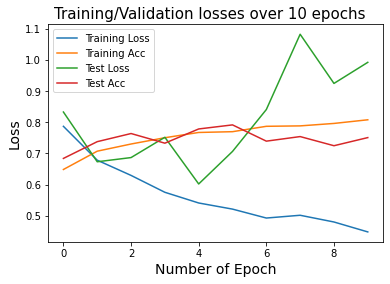

In [68]:
# Number of classes in the dataset
num_classes = 3

# Number of epochs to train for
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.densenet121(pretrained=False)
model_ft.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, num_classes)

# # Initialize the non-pretrained version of the model used for this run
scratch_model = model_ft.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

## VGG

  0%|          | 5/1304 [00:00<00:28, 46.15it/s]

Epoch: 1/10 -  Training Loss: 1.113 -  Training Accuracy: 0.616 -  Test Loss: 0.811 -  Test Accuracy: 0.655


  0%|          | 5/1304 [00:00<00:28, 45.73it/s]

Epoch: 2/10 -  Training Loss: 0.578 -  Training Accuracy: 0.743 -  Test Loss: 0.939 -  Test Accuracy: 0.663


  0%|          | 5/1304 [00:00<00:28, 45.72it/s]

Epoch: 3/10 -  Training Loss: 0.503 -  Training Accuracy: 0.788 -  Test Loss: 0.615 -  Test Accuracy: 0.832


  0%|          | 5/1304 [00:00<00:28, 45.75it/s]

Epoch: 4/10 -  Training Loss: 0.478 -  Training Accuracy: 0.790 -  Test Loss: 0.914 -  Test Accuracy: 0.713


  0%|          | 5/1304 [00:00<00:28, 45.81it/s]

Epoch: 5/10 -  Training Loss: 0.449 -  Training Accuracy: 0.805 -  Test Loss: 1.240 -  Test Accuracy: 0.611


  0%|          | 5/1304 [00:00<00:28, 45.66it/s]

Epoch: 6/10 -  Training Loss: 0.422 -  Training Accuracy: 0.813 -  Test Loss: 1.564 -  Test Accuracy: 0.643


  0%|          | 5/1304 [00:00<00:27, 46.64it/s]

Epoch: 7/10 -  Training Loss: 0.400 -  Training Accuracy: 0.825 -  Test Loss: 1.504 -  Test Accuracy: 0.629


  0%|          | 5/1304 [00:00<00:28, 46.31it/s]

Epoch: 8/10 -  Training Loss: 0.379 -  Training Accuracy: 0.832 -  Test Loss: 0.953 -  Test Accuracy: 0.739


  0%|          | 5/1304 [00:00<00:28, 46.31it/s]

Epoch: 9/10 -  Training Loss: 0.364 -  Training Accuracy: 0.837 -  Test Loss: 1.525 -  Test Accuracy: 0.695


100%|██████████| 154/154 [00:01<00:00, 129.52it/s]


Epoch: 10/10 -  Training Loss: 0.348 -  Training Accuracy: 0.849 -  Test Loss: 0.980 -  Test Accuracy: 0.783
Training complete in 4m 59s
Best val Acc: 0.832248


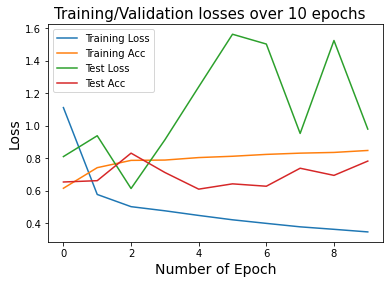

In [73]:
# Number of classes in the dataset
num_classes = 3

# Number of epochs to train for
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.vgg11_bn(pretrained=False)
model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

# # Initialize the non-pretrained version of the model used for this run
scratch_model = model_ft.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

## Squeezenet

  1%|          | 8/1304 [00:00<00:18, 71.82it/s]

Epoch: 1/10 -  Training Loss: 1.058 -  Training Accuracy: 0.479 -  Test Loss: 1.104 -  Test Accuracy: 0.394


  1%|          | 8/1304 [00:00<00:16, 76.52it/s]

Epoch: 2/10 -  Training Loss: 1.037 -  Training Accuracy: 0.488 -  Test Loss: 1.020 -  Test Accuracy: 0.402


  1%|          | 8/1304 [00:00<00:17, 75.31it/s]

Epoch: 3/10 -  Training Loss: 0.931 -  Training Accuracy: 0.570 -  Test Loss: 0.863 -  Test Accuracy: 0.624


  1%|          | 7/1304 [00:00<00:19, 67.51it/s]

Epoch: 4/10 -  Training Loss: 0.778 -  Training Accuracy: 0.640 -  Test Loss: 1.118 -  Test Accuracy: 0.515


  1%|          | 8/1304 [00:00<00:16, 78.70it/s]

Epoch: 5/10 -  Training Loss: 0.745 -  Training Accuracy: 0.655 -  Test Loss: 1.049 -  Test Accuracy: 0.635


  1%|          | 8/1304 [00:00<00:16, 78.87it/s]

Epoch: 6/10 -  Training Loss: 0.698 -  Training Accuracy: 0.672 -  Test Loss: 0.830 -  Test Accuracy: 0.658


  1%|          | 8/1304 [00:00<00:16, 77.66it/s]

Epoch: 7/10 -  Training Loss: 0.650 -  Training Accuracy: 0.692 -  Test Loss: 0.947 -  Test Accuracy: 0.679


  1%|          | 8/1304 [00:00<00:17, 75.58it/s]

Epoch: 8/10 -  Training Loss: 0.620 -  Training Accuracy: 0.705 -  Test Loss: 0.909 -  Test Accuracy: 0.603


  1%|          | 8/1304 [00:00<00:16, 78.56it/s]

Epoch: 9/10 -  Training Loss: 0.601 -  Training Accuracy: 0.718 -  Test Loss: 1.007 -  Test Accuracy: 0.629


100%|██████████| 154/154 [00:00<00:00, 154.35it/s]


Epoch: 10/10 -  Training Loss: 0.608 -  Training Accuracy: 0.713 -  Test Loss: 1.481 -  Test Accuracy: 0.508
Training complete in 3m 3s
Best val Acc: 0.679153


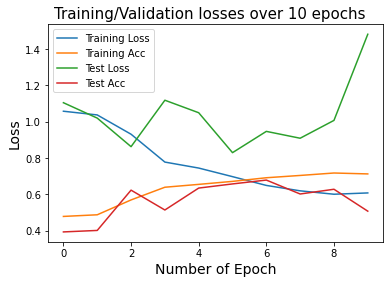

In [81]:
# Number of classes in the dataset
num_classes = 3

# Number of epochs to train for
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.squeezenet1_0(pretrained=False)
model_ft.features[0] = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2))
model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

# # Initialize the non-pretrained version of the model used for this run
scratch_model = model_ft.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)